In [471]:
import pandas as pd
import numpy as np
import googlemaps
from datetime import datetime
import acquire_r
from env import google_key, google_key1
from googlemaps import convert
import wrangle_zillow_r
import wrangle_zillow
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import gmaps
import gmaps.datasets
gmaps.configure(api_key=google_key1) # Fill in with your API key
%matplotlib inline
import zillow_fe
import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.metrics import median_absolute_error, r2_score, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from pygam import LogisticGAM, LinearGAM, s, f, te
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats
import evaluate
import explore
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
#df = acquire_r.get_zillow_data()
# df1 = df1.dropna()

In [3]:
#df.to_csv('zillow.csv')

In [861]:
zillow = wrangle_zillow.wrangle_zillow()

In [862]:
zillow = zillow.dropna()

In [863]:
zillow['median_income'] = zillow.median_income.str.strip()

In [865]:
zillow['median_income'] = zillow.median_income.str.replace(',', '').astype(float)

In [866]:
zillow.median_income

0         66044.0
1         66044.0
2         66044.0
3         66044.0
4         66044.0
           ...   
73742     62196.0
73744     68058.0
73746    108993.0
73748     76397.0
73751     53646.0
Name: median_income, Length: 64786, dtype: float64

In [7]:
#random state 539

In [867]:
train, test = train_test_split(zillow, train_size = .80, random_state = 539)
train, validate = train_test_split(train, train_size = .80, random_state = 539)

In [868]:
train['abs_logerror'] = abs(train.logerror)

### cluster the traget variable (logerror)

In [9]:
def cluster(train, X, k):
    scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 539)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    train['cluster'] = kmeans.predict(X_scaled)
    train['cluster'] = 'cluster_' + train.cluster.astype(str)
    return train, X_scaled, scaler, kmeans

def scatter_plot(x,y,train,kmeans, X_scaled, scaler):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = train, hue = 'cluster')
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')

In [16]:
X = train[['logerror']]

In [17]:
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
kmeans = KMeans(n_clusters = 5, random_state=539)
kmeans.fit(X_scaled)
kmeans.predict(X_scaled)
train['cluster'] = kmeans.predict(X_scaled)
train['cluster'] = 'cluster_' + train.cluster.astype(str)


In [18]:
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
centroids

logerror
0 -0.189317
1  0.359706
2 -2.435118
3  1.787421
4  0.011553

In [19]:
locations = train[train.cluster == 'cluster_2'][['latitude', 'longitude']]
weights = train[train.cluster == 'cluster_2']['logerror']
fig = gmaps.figure()
fig.add_layer(gmaps.symbol_layer(locations/1000000, fill_color='red', stroke_color='red', scale=2))
fig
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x = 'latitude', y = 'longitude', data = train[train.cluster =='cluster_1'], hue = 'cluster')
#gmaps.figure(center=(34.069091, -118.284055), zoom_level=12)

# fig.add_layer(gmaps.heatmap_layer(locations/1000000, weights = weights))
# gmaps.figure(center=(34.069091, -118.284055), zoom_level=12)


Figure(layout=FigureLayout(height='420px'))

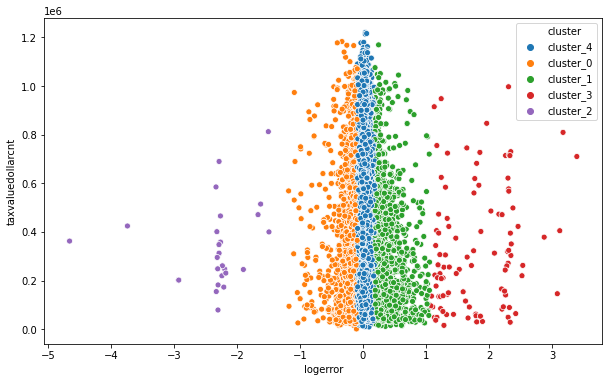

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'taxvaluedollarcnt', data = train, hue = 'cluster')

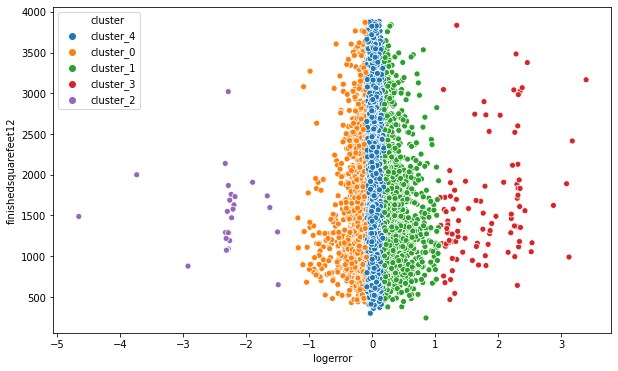

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'finishedsquarefeet12', data = train, hue = 'cluster')

(90000.0, 94000.0)

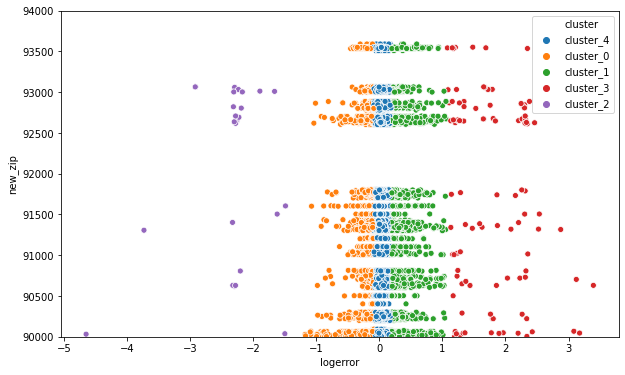

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'new_zip', data = train, hue = 'cluster')
plt.ylim(90000, 94000)

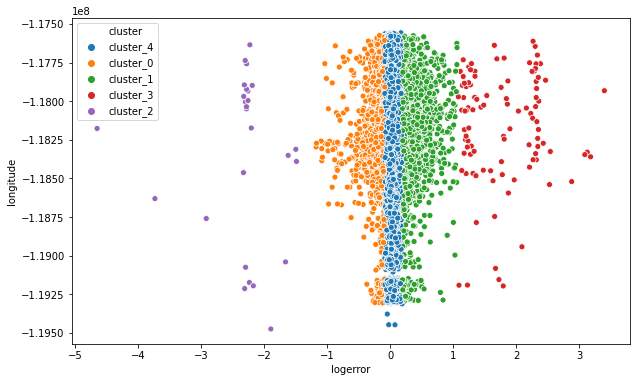

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'longitude', data = train, hue = 'cluster')

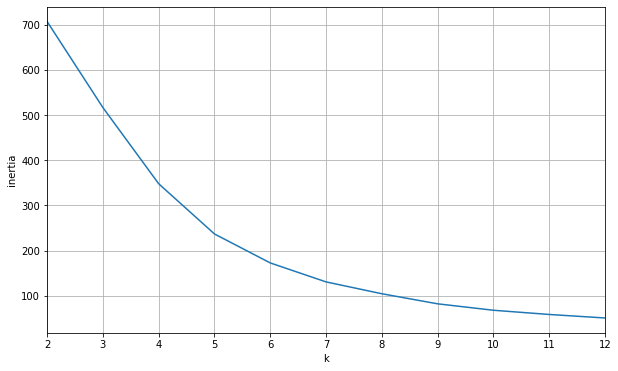

In [24]:
def get_inertia(k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

### Cluster Independent Variables

Location, that is, latitude and longitude\
Size (finished square feet)\
Location and size\
Be sure to use these new clusters in exploring your data, and interpret what these clusters tell you.

In [438]:
train = train.drop(columns = 'cluster')

In [439]:
X = train[['latitude', 'longitude']]

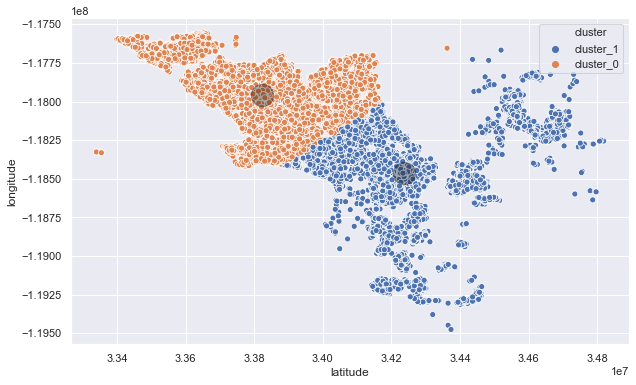

In [440]:
train, X_scaled, scaler, kmeans = cluster(train, X, 2)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
scatter_plot('latitude','longitude',train,kmeans, X_scaled, scaler)

In [860]:
# heatmap_layer.max_intensity = 5
# heatmap_layer.point_radius = 2


In [859]:
locations = train[['latitude', 'longitude']]
weights = train['logerror']
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(locations/1000000, weights = abs(weights))
fig.add_layer(heatmap_layer)
#fig.add_layer(gmaps.symbol_layer(locations/1000000, fill_color='red', stroke_color='red', scale=2))
fig

Figure(layout=FigureLayout(height='420px'))

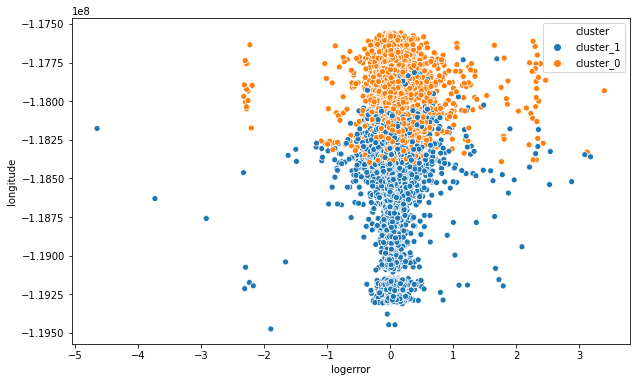

In [143]:
#scatter_plot('logerror','longitude',train,kmeans, X_scaled, scaler)
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'longitude', data = train, hue = 'cluster')

(-1.0, 1.0)

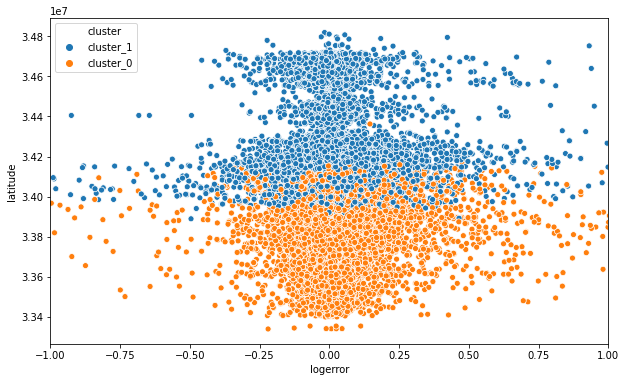

In [144]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'latitude', data = train, hue = 'cluster')
plt.xlim(-1,1)

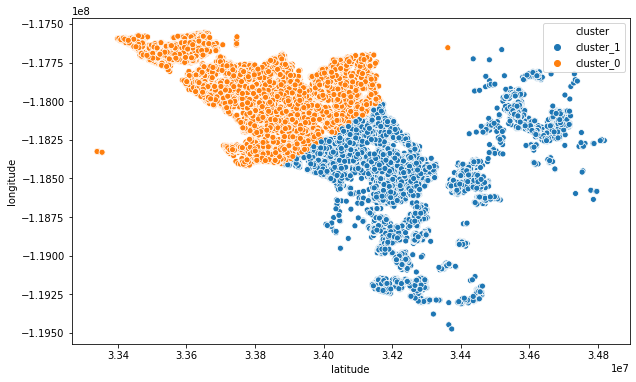

In [145]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y = 'longitude', x = 'latitude', data = train, hue = 'cluster')
#plt.xlim(-1,1)

In [442]:
centroids

latitude     longitude
0  3.382369e+07 -1.179597e+08
1  3.423521e+07 -1.184635e+08

In [441]:
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
print(train[train.cluster == 'cluster_2'].logerror.mean())
print(train[train.cluster == 'cluster_3'].logerror.mean())
print(train[train.cluster == 'cluster_4'].logerror.mean())

0.01785648276219217
0.009003700795136158
nan
nan
nan


In [148]:
x1 = train[train.cluster == 'cluster_0'].logerror
x2 = train[train.cluster == 'cluster_1'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=5.535876222142992, pvalue=3.1154765389590724e-08)

## There is significant difference in logerror between cluster 0 and 1

In [322]:
# lets cluster based on size (sqft)
X = train[['finishedsquarefeet12','logerror']]

(-1.0, 1.0)

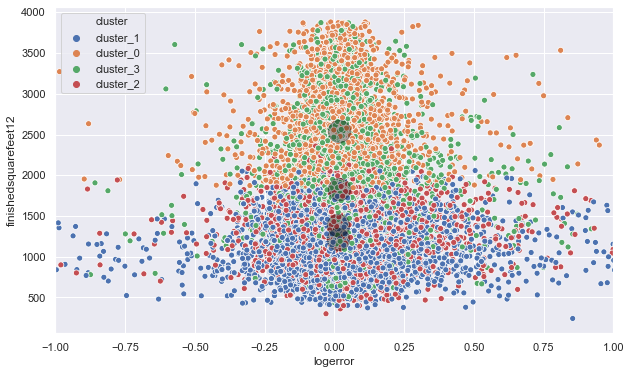

In [453]:
train, X_scaled, scaler, kmeans = cluster(train, X, 4)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)


scatter_plot('logerror','finishedsquarefeet12',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)

In [454]:
centroids

latitude     longitude  finishedsquarefeet12  logerror
0  3.422889e+07 -1.183534e+08           2540.617752  0.018255
1  3.394743e+07 -1.181298e+08           1215.995014  0.011485
2  3.428853e+07 -1.185625e+08           1395.338928  0.012187
3  3.370555e+07 -1.178017e+08           1835.508975  0.017760

In [452]:
x1 = train[train.cluster == 'cluster_2'].logerror
x2 = train[train.cluster == 'cluster_1'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=0.635589441071954, pvalue=0.5250487795776504)

In [443]:
X = train[['latitude', 'longitude', 'finishedsquarefeet12', 'logerror']]

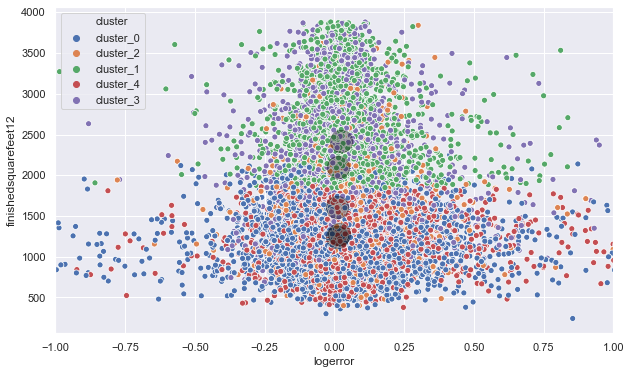

In [444]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
scatter_plot('logerror','finishedsquarefeet12',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

(-1.0, 1.0)

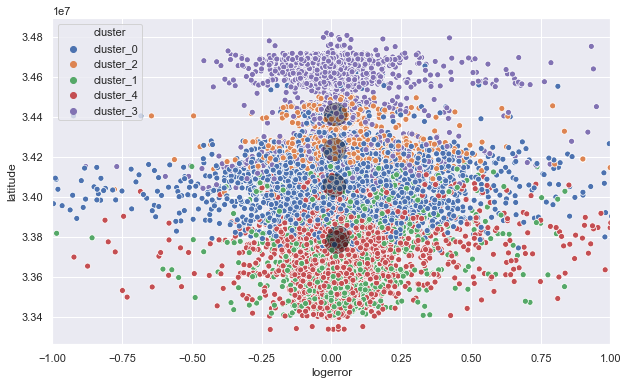

In [445]:
scatter_plot('logerror','latitude',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)

(-1.0, 1.0)

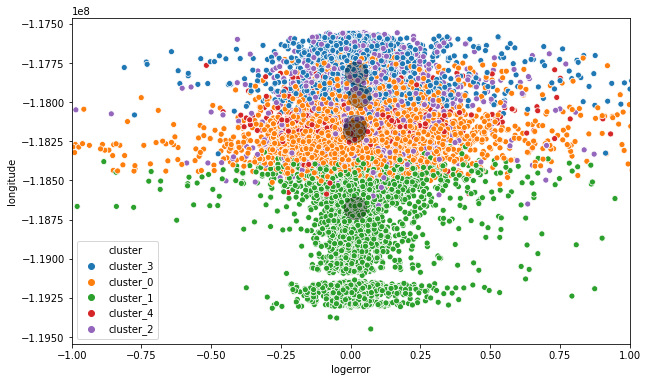

In [327]:
scatter_plot('logerror','longitude',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)

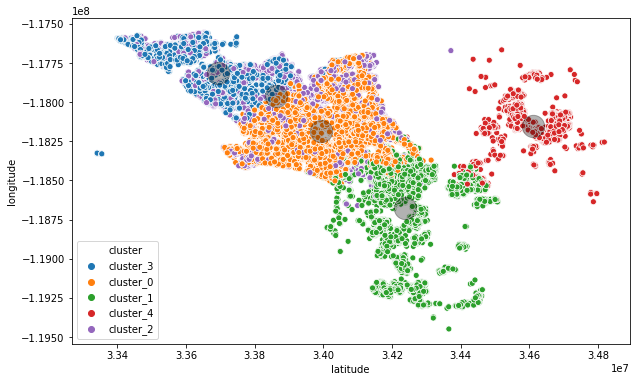

In [328]:
scatter_plot('latitude','longitude',train,kmeans, X_scaled, scaler)

In [869]:
X = validate[['taxvaluedollarcnt', 'median_income']]
validate, X_scaled, scaler, kmeans = cluster(validate, X, 3)
#scatter_plot('taxvaluedollarcnt','median_income',train,kmeans, X_scaled, scaler)
#plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

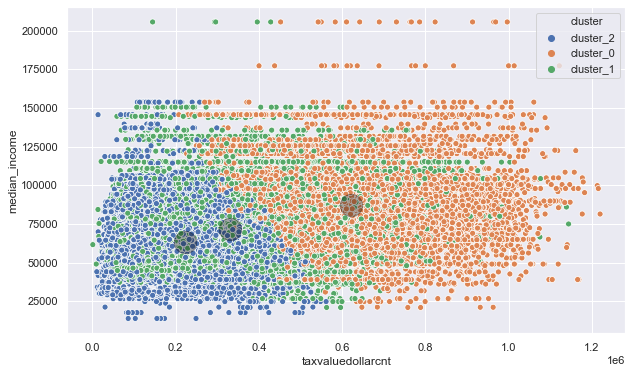

In [825]:
X = train[['taxvaluedollarcnt', 'median_income', 'latitude', 'longitude']]
train, X_scaled, scaler, kmeans = cluster(train, X, 3)
scatter_plot('taxvaluedollarcnt','median_income',train,kmeans, X_scaled, scaler)
#plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

In [826]:
centroids['ratio1'] = centroids.taxvaluedollarcnt/centroids.median_income
centroids

taxvaluedollarcnt  median_income      latitude     longitude    ratio1
0      621732.987920   87112.589003  3.381062e+07 -1.179596e+08  7.137120
1      330785.166535   71769.300926  3.428755e+07 -1.185167e+08  4.609006
2      221947.497700   63411.473307  3.389434e+07 -1.180454e+08  3.500116

In [827]:
train[train.cluster == 'cluster_0'].logerror.mean()

0.014379592438891121

In [828]:
train[train.cluster == 'cluster_1'].logerror.mean()

0.012060508885705791

In [829]:
train[train.cluster == 'cluster_2'].logerror.mean()

0.015225188268596375

In [830]:
x1 = train[train.cluster == 'cluster_0'].logerror
x2 = train[train.cluster == 'cluster_2'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-0.4224962625040313, pvalue=0.6726661316353459)

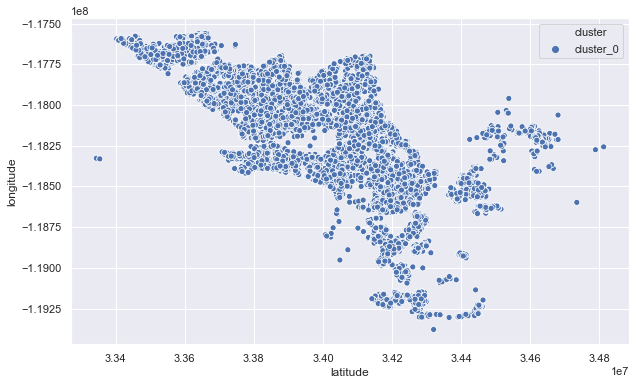

In [824]:
plt.figure(figsize=(10, 6))
data1 = train[train.cluster == 'cluster_0']
sns.scatterplot(y = 'longitude', x = 'latitude', data = data1, hue = 'cluster')
#plt.xlim(-1,1)

In [271]:
train['value_income'] = train.taxvaluedollarcnt/train.median_income

In [272]:
X = train[['value_income', 'logerror']]

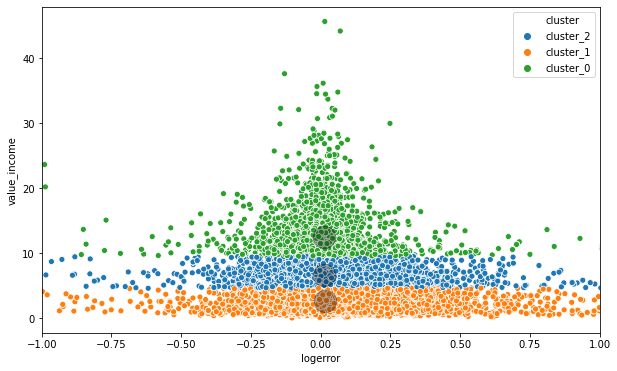

In [275]:
train, X_scaled, scaler, kmeans = cluster(train, X, 3)
scatter_plot('logerror','value_income',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

In [276]:
centroids

value_income  logerror
0     12.452441  0.011857
1      2.648976  0.016321
2      6.562829  0.011609

In [363]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41492 entries, 59579 to 19482
Data columns (total 38 columns):
Unnamed: 0                    41492 non-null float64
airconditioningtypeid         41492 non-null object
basementsqft                  41492 non-null int64
bathroomcnt                   41492 non-null int64
bedroomcnt                    41492 non-null int64
buildingqualitytypeid         41492 non-null object
decktypeid                    41492 non-null object
finishedsquarefeet12          41492 non-null int64
fireplacecnt                  41492 non-null int64
garagecarcnt                  41492 non-null int64
garagetotalsqft               41492 non-null int64
hashottuborspa                41492 non-null int64
heatingorsystemtypeid         41492 non-null object
latitude                      41492 non-null float64
longitude                     41492 non-null float64
lotsizesquarefeet             41492 non-null int64
poolcnt                       41492 non-null int64
poolsizesu

In [364]:
X = train[['bathroomcnt', 'logerror']]

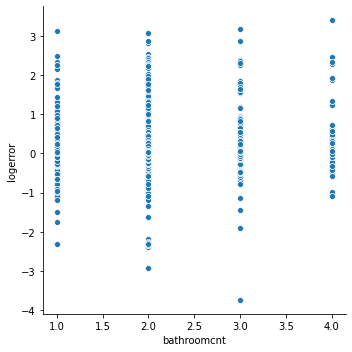

In [365]:
sns.relplot(y = 'logerror', x = 'bathroomcnt', data = train)

In [366]:
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
print(train[train.cluster == 'cluster_2'].logerror.mean())
print(train[train.cluster == 'cluster_3'].logerror.mean())

0.009808542392645751
0.015367188618411189
0.020785911308976092
nan


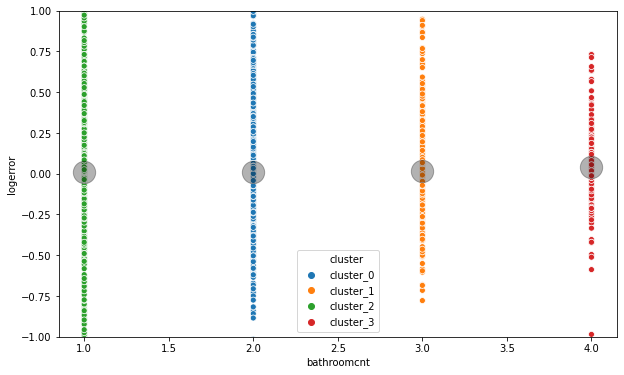

In [367]:
train, X_scaled, scaler, kmeans = cluster(train, X, 4)
scatter_plot('bathroomcnt','logerror',train,kmeans, X_scaled, scaler)
plt.ylim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

### Lets create a variable which is average number of properties by zip

In [368]:
zip_count = pd.DataFrame(train.new_zip.value_counts()).reset_index().rename(columns = {'index': 'new_zip', 'new_zip': 'zip_count'})

In [369]:
mapping = dict(zip_count[['new_zip', 'zip_count']].values)
train['zip_count'] = train.new_zip.map(mapping)
train.head(2)

Unnamed: 0 airconditioningtypeid  basementsqft  bathroomcnt  \
59579     63182.0                     0             0            2   
61336     64925.0                     0             0            3   

       bedroomcnt buildingqualitytypeid decktypeid  finishedsquarefeet12  \
59579           4                     4          0                  2349   
61336           4                     5          0                  2353   

       fireplacecnt  garagecarcnt  ...  logerror  transactiondate  \
59579             1             2  ... -0.350256       2017-05-17   
61336             0             2  ... -0.007522       2017-03-10   

      haversine_distance  regionid_zip  census_tractandblock  new_zip  \
59579         145.170455       96982.0           6.05904e+13  92672.0   
61336         121.241758       96993.0           6.05903e+13  92688.0   

       median_income  county    cluster  zip_count  
59579        71928.0  Orange  cluster_0      184.0  
61336        96983.0  Orange  cluster_1      404.0  

[2 rows x 39 columns]

In [370]:
X = train[['zip_count', 'logerror', 'taxvaluedollarcnt']]

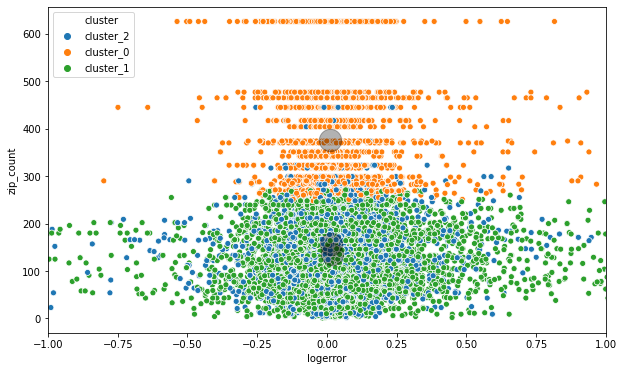

In [371]:
train, X_scaled, scaler, kmeans = cluster(train, X, 3)
scatter_plot('logerror','zip_count',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

In [372]:
centroids

zip_count  logerror  taxvaluedollarcnt
0  376.513933  0.009628      294144.759369
1  136.416323  0.016410      227269.571131
2  156.229653  0.013002      622557.170078

In [373]:
x1 = train[train.cluster == 'cluster_0'].logerror
x2 = train[train.cluster == 'cluster_2'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-1.4119720353703207, pvalue=0.15797387417047834)

### Does not look like there are not significant features driving logerror

In [10]:
zillow

Unnamed: 0 airconditioningtypeid  basementsqft  bathroomcnt  \
0             0.0                     0             0            2   
1             1.0                     1             0            2   
2             2.0                     1             0            2   
3             3.0                     0             0            2   
4             4.0                     0             0            2   
...           ...                   ...           ...          ...   
73742     77558.0                     0             0            3   
73744     77560.0                     0             0            1   
73746     77565.0                     1             0            3   
73748     77567.0                     1             0            2   
73751     77573.0                     1             0            3   

       bedroomcnt buildingqualitytypeid decktypeid  finishedsquarefeet12  \
0               3                     8          0                  2107   
1               4                     8          0                  1882   
2               4                     8          0                  1882   
3               3                     8          0                  1477   
4               4                     8          0                  1918   
...           ...                   ...        ...                   ...   
73742           3                     4          0                  1850   
73744           2                     7          0                   756   
73746           3                     4          0                  2108   
73748           2                     4          0                  1480   
73751           3                     4          0                  1661   

       fireplacecnt  garagecarcnt  ...  taxdelinquencyflag  \
0                 0             0  ...                   0   
1                 0             0  ...                   0   
2                 0             0  ...                   0   
3                 0             0  ...                   0   
4                 0             0  ...                   0   
...             ...           ...  ...                 ...   
73742             0             0  ...                   0   
73744             0             0  ...                   0   
73746             0             0  ...                   0   
73748             0             0  ...                   0   
73751             0             0  ...                   0   

       taxdelinquencyyear  logerror  transactiondate  haversine_distance  \
0                       0 -0.007357       2017-07-07           87.506921   
1                       0  0.021066       2017-08-29           87.601806   
2                       0  0.077174       2017-04-04           87.474112   
3                       0 -0.041238       2017-03-17           87.440105   
4                       0 -0.009496       2017-03-24           87.494754   
...                   ...       ...              ...                 ...   
73742                   0  0.063190       2017-07-11          104.345462   
73744                   0 -0.217256       2017-01-19          106.100377   
73746                   0 -0.158701       2017-06-14           73.622987   
73748                   0 -0.009925       2017-01-31           69.199412   
73751                   0  0.006706       2017-02-03           76.796299   

       regionid_zip  census_tractandblock  new_zip median_income       county  
0           96339.0           6.03711e+13  91304.0       66044.0  Los_Angeles  
1           96339.0           6.03711e+13  91304.0       66044.0  Los_Angeles  
2           96339.0           6.03711e+13  91304.0       66044.0  Los_Angeles  
3           96339.0           6.03711e+13  91304.0       66044.0  Los_Angeles  
4           96339.0           6.03711e+13  91304.0       66044.0  Los_Angeles  
...             ...                   ...      ...           ...          ...  
73742       97047.0           6.037

In [676]:
zillow1 = zillow_fe.zillow_fe(zillow)
zillow1['living_area_prop'] = (zillow1.lotsizesquarefeet/zillow1.finishedsquarefeet12)


train, test = train_test_split(zillow1, train_size = .80, random_state = 539)
train, validate = train_test_split(train, train_size = .80, random_state = 539)

In [675]:
zillow1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64786 entries, 0 to 73751
Data columns (total 47 columns):
Unnamed: 0                    64786 non-null float64
bathroomcnt                   64786 non-null int64
bedroomcnt                    64786 non-null int64
buildingqualitytypeid         64786 non-null object
finishedsquarefeet12          64786 non-null int64
garagecarcnt                  64786 non-null int64
garagetotalsqft               64786 non-null int64
hashottuborspa                64786 non-null int64
latitude                      64786 non-null float64
longitude                     64786 non-null float64
lotsizesquarefeet             64786 non-null int64
poolcnt                       64786 non-null int64
poolsizesum                   64786 non-null int64
roomcnt                       64786 non-null int64
numberofstories               64786 non-null int64
structuretaxvaluedollarcnt    64786 non-null int64
taxvaluedollarcnt             64786 non-null int64
landtaxvaluedolla

In [418]:
X = train[['age', 'logerror']]

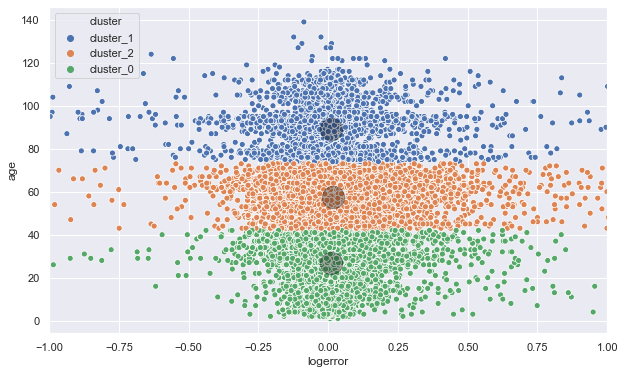

In [419]:
train, X_scaled, scaler, kmeans = cluster(train, X, 3)
scatter_plot('logerror', 'age',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
#plt.ylim(0,0.05)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

In [420]:
centroids

age  logerror
0  27.012418  0.010765
1  89.120357  0.008548
2  57.603499  0.018132

In [873]:
x1 = train[train.cluster == 'cluster_0'].logerror
x2 = train[train.cluster == 'cluster_1'].logerror
stats.ttest_ind(x1, x2)

AttributeError: 'DataFrame' object has no attribute 'cluster'

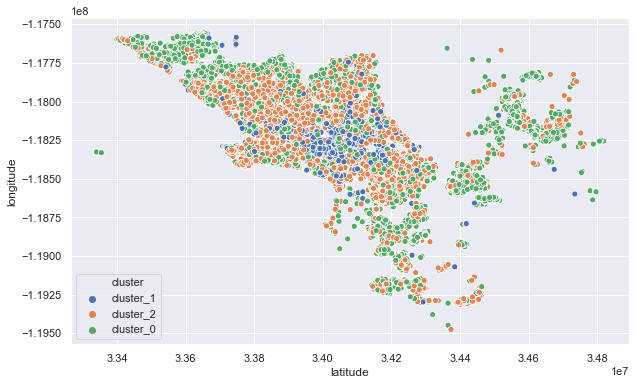

In [422]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y = 'longitude', x = 'latitude', data = train, hue = 'cluster')
#plt.xlim(-1,1)

### Age seems to be a factor in logerror. Older homes seems to have higher logerror

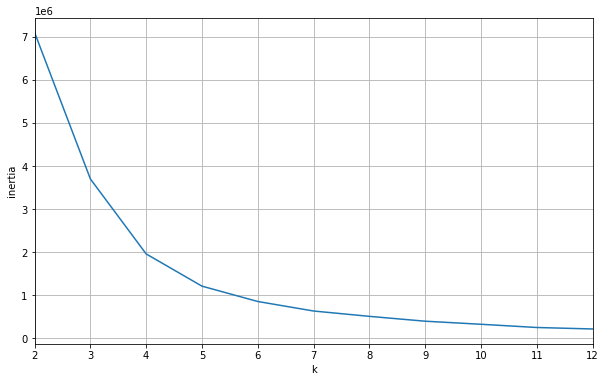

In [130]:
def get_inertia(k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

In [187]:
X = train[['age', 'latitude' , 'longitude', 'logerror']]

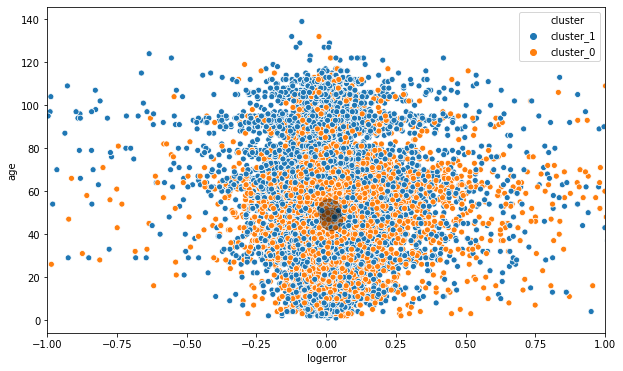

In [191]:
train, X_scaled, scaler, kmeans = cluster(train, X, 2)
scatter_plot('logerror', 'age',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
#plt.ylim(0,0.05)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

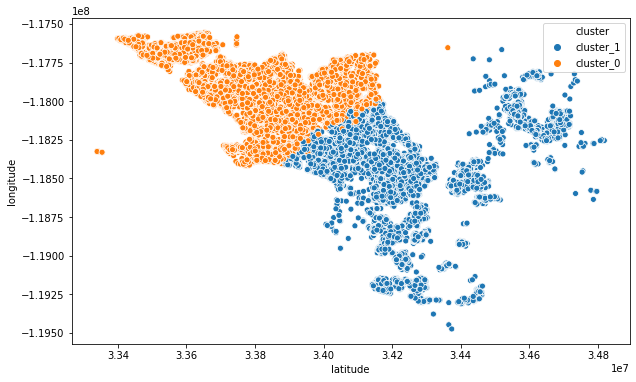

In [192]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y = 'longitude', x = 'latitude', data = train, hue = 'cluster')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

In [193]:
centroids

age      latitude     longitude  logerror
0  46.888829  3.381691e+07 -1.179498e+08  0.017671
1  51.221053  3.422464e+07 -1.184524e+08  0.009629

In [169]:
x1 = train[train.cluster == 'cluster_0'].logerror
x2 = train[train.cluster == 'cluster_1'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=5.078365211294333, pvalue=3.823427188035133e-07)

In [175]:
pd.DataFrame(kmeans.predict(X_scaled), c)

0
0      1
1      0
2      1
3      0
4      0
...   ..
41457  1
41458  1
41459  1
41460  1
41461  0

[41462 rows x 1 columns]

In [186]:

train_clusters = pd.DataFrame(kmeans.predict(X_scaled), columns = ['age_cluster'], index = X.index)
cluster_counts = train_clusters['age_cluster'].value_counts()
cluster_counts

0    22235
1    19227
Name: age_cluster, dtype: int64

In [ ]:
X = train[['age', 'latitude' , 'longitude', 'logerror']]
var_list = train[['age', 'latitude' , 'longitude', 'logerror']]

In [229]:
train['sqft_price'] = train.taxvaluedollarcnt/zillow1.finishedsquarefeet12

In [230]:
X = train[['sqft_price', 'logerror']]

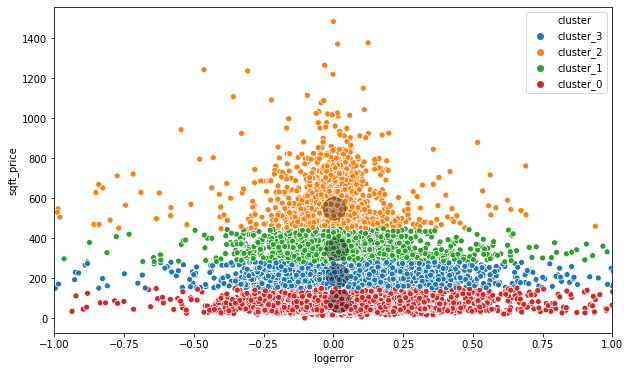

In [242]:
train, X_scaled, scaler, kmeans = cluster(train, X, 4)
scatter_plot('logerror', 'sqft_price',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
#plt.ylim(0,0.2)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
#sns.scatterplot(y = 'sqft_price', x = 'logerror', data = train, hue = 'cluster')

In [243]:
centroids

sqft_price  logerror
0   83.922754  0.021508
1  345.107093  0.008732
2  549.060744  0.001626
3  215.147156  0.014523

In [249]:
x1 = train[train.cluster == 'cluster_2'].logerror
x2 = train[train.cluster == 'cluster_3'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-3.713053941688863, pvalue=0.00020540442239580327)

In [474]:
train.cluster.value_counts()

cluster_1    17803
cluster_0    16286
cluster_2     7373
Name: cluster, dtype: int64

## Modeling

In [872]:
def encode(train, col_name):

    encoded_values = sorted(list(train[col_name].unique()))

    # Integer Encoding
    int_encoder = LabelEncoder()
    train.encoded = int_encoder.fit_transform(train[col_name])
    validate.encoded = int_encoder.transform(validate[col_name])
    test.encoded = int_encoder.transform(test[col_name])

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train.encoded).reshape(len(train.encoded),1)
    validate_array = np.array(validate.encoded).reshape(len(validate.encoded),1)
    test_array = np.array(test.encoded).reshape(len(test.encoded),1)

    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    validate_ohe = ohe.fit_transform(validate_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=encoded_values, index=train.index)
    train = train.join(train_encoded)
    
    test_encoded = pd.DataFrame(data=test_ohe,
                               columns=encoded_values, index=test.index)
    test = test.join(test_encoded)
    
    validate_encoded = pd.DataFrame(data=test_ohe,
                               columns=encoded_values, index=validate.index)
    validate = validate.join(validate_encoded)

    return train, validate, test

In [871]:
train, validate, test = encode(train, 'cluster')

KeyError: 'cluster'

In [759]:
validate = encode(validate, 'cluster')

In [540]:
X = train[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12',  'latitude', 'longitude' ,'age', 'median_income','cluster_0', 'cluster_1', 'cluster_2']]
y = train[['logerror']]
feature_selection.rfe(X, y, 7)

Index(['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'age', 'cluster_0',
       'cluster_1', 'cluster_2'],
      dtype='object')

In [734]:
X_train = train[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'age', 'cluster_0',
       'cluster_1', 'cluster_2']]
y_train = train[['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)
X_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.values).set_index([X_train.index.values])

In [735]:
predictions = pd.DataFrame({
    'actual': y_train.logerror
})
predictions.head(2)

actual
22050  0.006085
38636 -0.047739

In [736]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('logerror ~ bathroomcnt + bedroomcnt + finishedsquarefeet12 + age +cluster_0+cluster_1 + cluster_2',  data = train).fit()

# compute predictions and add to original dataframe
predictions['ols'] = ols_model.predict(X_scaled)

In [737]:
predictions

actual       ols
22050  0.006085 -0.009652
38636 -0.047739 -0.009825
73295  0.000555 -0.009224
59749 -0.001202 -0.009577
55553  0.009874 -0.008618
...         ...       ...
10087  0.000327 -0.009827
12014  0.029701  0.003373
16782 -0.008003 -0.010256
1759  -0.006350 -0.008191
64511 -0.004499  0.001740

[41462 rows x 2 columns]

In [738]:
float('{:.3f}'.format(sqrt(mean_squared_error(predictions.actual, predictions.ols))))

0.163

In [739]:
float('{:.3f}'.format(r2_score(predictions.actual, predictions.ols)))

-0.012

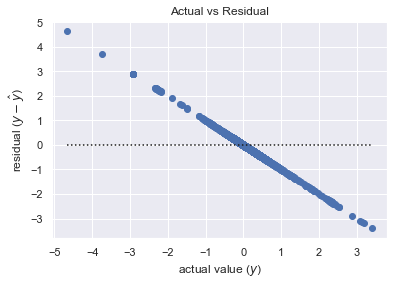

In [548]:
evaluate.plot_residuals(predictions.actual, predictions.ols, predictions)

In [327]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     27.15
Date:                Thu, 07 May 2020   Prob (F-statistic):           1.56e-17
Time:                        14:20:21   Log-Likelihood:                 16741.
No. Observations:               41462   AIC:                        -3.347e+04
Df Residuals:                   41458   BIC:                        -3.344e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0133      0.003      3.820      0.000       0.006       0.020
bathroomcnt     0.0016      0.001      1.289      0.198      -0.001       0.004
bedroomcnt      0.0025      0.001      2.437      0.015       0.000       0.005
sqft_price  -4.233e-05   5.91e-06     -7.160      0.000   -5.39e-05   -3.07e-05
==============================================================================
Omnibus:                    24899.413   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26482748.761
Skew:                           1.422   Prob(JB):                         0.00
Kurtosis:                     126.779   Cond. No.                     1.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Polynomial model

In [740]:
X_train = train[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'age', 'cluster_0',
       'cluster_1', 'cluster_2']]
y_train = train[['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)
X_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.values).set_index([X_train.index.values])

In [741]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [742]:
y_train['predicted_poly'] = lm_poly.predict(X_poly)

In [743]:
y_train

logerror  predicted_poly
22050  0.006085        0.004639
38636 -0.047739       -0.001465
73295  0.000555        0.021973
59749 -0.001202        0.028076
55553  0.009874        0.007202
...         ...             ...
10087  0.000327       -0.004639
12014  0.029701        0.019653
16782 -0.008003        0.004272
1759  -0.006350        0.017090
64511 -0.004499        0.018066

[41462 rows x 2 columns]

In [744]:
float('{:.3f}'.format(sqrt(mean_squared_error(y_train.logerror, y_train.predicted_poly))))

0.161

In [745]:
float('{:.3f}'.format(r2_score(y_train.logerror, y_train.predicted_poly)))

0.003

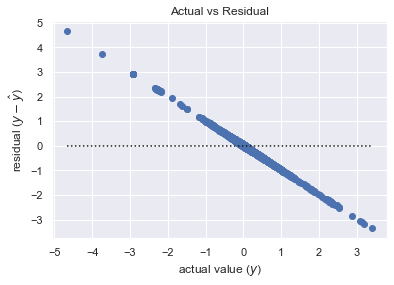

In [746]:
evaluate.plot_residuals(y_train.logerror, y_train.predicted_poly, y_train)

## GAM Models

In [747]:
X_train = train[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'age', 'cluster_0',
       'cluster_1', 'cluster_2']]
y_train = train[['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)
X_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.values).set_index([X_train.index.values])

In [748]:
X_scaled= X_scaled.to_numpy()
y_train = y_train.to_numpy()

In [749]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1) +s(2) + s(3) +s(4) + s(5)+s(6))

In [750]:
gam.gridsearch(X_scaled,y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + intercept, 
   tol=0.0001, verbose=False)

In [751]:
y_pred = gam.predict(X_scaled)

In [752]:
y_pred = pd.DataFrame(y_pred)

In [753]:
y_pred['actual'] =y_train

In [754]:
y_pred.columns = ['predicted', 'actual']

In [755]:
float('{:.3f}'.format(sqrt(mean_squared_error(y_pred.actual, y_pred.predicted))))

0.161

In [756]:
float('{:.3f}'.format(r2_score(y_pred.actual, y_pred.predicted)))

0.004

In [661]:
def plot_scatter(x,y):
    f, (ax1) = plt.subplots(1, 1)
    plt.figure(figsize = (12,8))
    ax1.scatter(x, y)
    ax1.plot([0, 0.2], [0, 0.2], '--k')
    ax1.set_ylabel('Target predicted')
    ax1.set_xlabel('True Target')
    ax1.set_title('Target vs Predicted')
    ax1.text(0.1, 0.1, r'$R^2$=%.2f, MAE=%.2f' % (r2_score(x, y), mean_absolute_error(x, y)))
    ax1.set_xlim([0, 0.2])
    ax1.set_ylim([0, 0.2])
    plt.show()

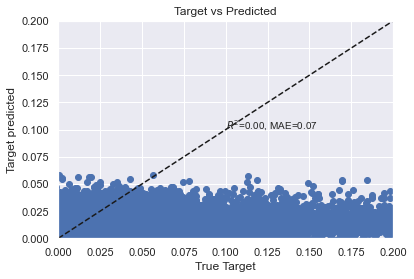

<Figure size 864x576 with 0 Axes>

In [584]:
plot_scatter(y_pred['actual'], y_pred['predicted'])


In [538]:
float('{:.3f}'.format(r2_score(y_train, y_pred)))

0.002

# Modeling on individual clusters

In [662]:
X_train = train[train.cluster=='cluster_1'][['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12','taxvaluedollarcnt', 'median_income']]
y_train = train[train.cluster=='cluster_1'][['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)
X_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.values).set_index([X_train.index.values])

In [642]:
#polynomial model cluster1
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['predicted_poly'] = lm_poly.predict(X_poly)
float('{:.3f}'.format(sqrt(mean_squared_error(y_train.logerror, y_train.predicted_poly))))

0.17

In [663]:
#GAM Model cluster1
X_scaled= X_scaled.to_numpy()
y_train = y_train.to_numpy()
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1) +s(2) + s(3) +s(4))
gam.gridsearch(X_scaled,y_train)
y_pred = gam.predict(X_scaled)
y_pred = pd.DataFrame(y_pred)
y_pred['actual'] =y_train
y_pred.columns = ['predicted', 'actual']
float('{:.3f}'.format(sqrt(mean_squared_error(y_pred.actual, y_pred.predicted))))

100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


0.17

In [664]:
X_train = train[train.cluster=='cluster_2'][['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12','taxvaluedollarcnt', 'median_income']]
y_train = train[train.cluster=='cluster_2'][['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)
X_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.values).set_index([X_train.index.values])

In [640]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['predicted_poly'] = lm_poly.predict(X_poly)
float('{:.3f}'.format(sqrt(mean_squared_error(y_train.logerror, y_train.predicted_poly))))

0.157

In [665]:
#GAM Model # cluster2
X_scaled= X_scaled.to_numpy()
y_train = y_train.to_numpy()
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1) +s(2) + s(3) +s(4))
gam.gridsearch(X_scaled,y_train)
y_pred = gam.predict(X_scaled)
y_pred = pd.DataFrame(y_pred)
y_pred['actual'] =y_train
y_pred.columns = ['predicted', 'actual']
float('{:.3f}'.format(sqrt(mean_squared_error(y_pred.actual, y_pred.predicted))))

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


0.157

In [666]:
X_train = train[train.cluster=='cluster_0'][['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12','taxvaluedollarcnt', 'median_income']]
y_train = train[train.cluster=='cluster_0'][['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)
X_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.values).set_index([X_train.index.values])

In [638]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['predicted_poly'] = lm_poly.predict(X_poly)
float('{:.3f}'.format(sqrt(mean_squared_error(y_train.logerror, y_train.predicted_poly))))

0.153

In [667]:
#GAM Model # cluster0
X_scaled= X_scaled.to_numpy()
y_train = y_train.to_numpy()
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1) +s(2) + s(3) +s(4))
gam.gridsearch(X_scaled,y_train)
y_pred = gam.predict(X_scaled)
y_pred = pd.DataFrame(y_pred)
y_pred['actual'] =y_train
y_pred.columns = ['predicted', 'actual']
float('{:.3f}'.format(sqrt(mean_squared_error(y_pred.actual, y_pred.predicted))))

100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


0.153

# By County

In [843]:
train_LA = train[train.county == 'Los_Angeles']
train_OC = train[train.county == 'Orange']
train_VC = train[train.county == 'Ventura']

validate_LA = validate[validate.county == 'Los_Angeles']
validate_OC = validate[validate.county == 'Orange']
validate_VC = validate[validate.county == 'Ventura']

In [846]:
X_train = train_LA[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12','taxvaluedollarcnt']]
y_train = train_LA[['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)
#X_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.values).set_index([X_train.index.values])

In [847]:
#polynomial model cluster1
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['predicted_poly'] = lm_poly.predict(X_poly)
print(float('{:.3f}'.format(sqrt(mean_squared_error(y_train.logerror, y_train.predicted_poly)))))
float('{:.3f}'.format((median_absolute_error(y_train.logerror, y_train.predicted_poly))))

0.154


0.035

In [848]:
X_validate = validate_LA[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12','taxvaluedollarcnt']]
y_validate = validate_LA[['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_validate)
X_scaled = pd.DataFrame(scaler.transform(X_validate), columns=X_validate.columns.values).set_index([X_validate.index.values])

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_validate)
y_validate['predicted_poly'] = lm_poly.predict(X_poly)
print(float('{:.3f}'.format(sqrt(mean_squared_error(y_validate.logerror, y_validate.predicted_poly)))))
#float('{:.3f}'.format((median_absolute_error(y_validate.logerror, y_validate.predicted_poly))))

0.158


In [717]:
train.logerror.mean()

0.013948934578817171

In [718]:
y_train["mean_logerror"] = y_train.logerror.mean()
median_abs_error_base = sqrt(mean_squared_error(y_train.logerror,y_train.mean_logerror))
#print("Median absolute error for the baseline:")
#print(median_abs_error_base)

In [719]:
median_abs_error_base

0.15471696746956737

In [849]:
X_train = train_OC[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12','taxvaluedollarcnt']]
y_train = train_OC[['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)
#X_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.values).set_index([X_train.index.values])

In [850]:
#polynomial model cluster1
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['predicted_poly'] = lm_poly.predict(X_poly)
print(float('{:.3f}'.format(sqrt(mean_squared_error(y_train.logerror, y_train.predicted_poly)))))


0.162


In [852]:
X_validate = validate_OC[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12','taxvaluedollarcnt', 'median_income']]
y_validate = validate_OC[['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_validate)
X_scaled = pd.DataFrame(scaler.transform(X_validate), columns=X_validate.columns.values).set_index([X_validate.index.values])

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_validate)
y_validate['predicted_poly'] = lm_poly.predict(X_poly)
print(float('{:.3f}'.format(sqrt(mean_squared_error(y_validate.logerror, y_validate.predicted_poly)))))
#float('{:.3f}'.format((median_absolute_error(y_validate.logerror, y_validate.predicted_poly))))

0.179


In [854]:
X_train = train_VC[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12','taxvaluedollarcnt', 'median_income']]
y_train = train_VC[['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)
#X_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.values).set_index([X_train.index.values])

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['predicted_poly'] = lm_poly.predict(X_poly)
print(float('{:.3f}'.format(sqrt(mean_squared_error(y_train.logerror, y_train.predicted_poly)))))



0.21


In [855]:
X_validate = validate_VC[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12','taxvaluedollarcnt']]
y_validate = validate_VC[['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_validate)
X_scaled = pd.DataFrame(scaler.transform(X_validate), columns=X_validate.columns.values).set_index([X_validate.index.values])

In [856]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_scaled)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_validate)
y_validate['predicted_poly'] = lm_poly.predict(X_poly)
print(float('{:.3f}'.format(sqrt(mean_squared_error(y_validate.logerror, y_validate.predicted_poly)))))
#float('{:.3f}'.format((median_absolute_error(y_validate.logerror, y_validate.predicted_poly))))

0.121


In [ ]:
v

## Run model on validate set

In [802]:
X_validate = validate[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'age','cluster_0',
       'cluster_1', 'cluster_2']]
y_validate = validate[['logerror']]
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_validate)
X_scaled = pd.DataFrame(scaler.transform(X_validate), columns=X_validate.columns.values).set_index([X_validate.index.values])

In [799]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_scaled)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_validate)
y_validate['predicted_poly'] = lm_poly.predict(X_poly)
print(float('{:.3f}'.format(sqrt(mean_squared_error(y_validate.logerror, y_validate.predicted_poly)))))
#float('{:.3f}'.format((median_absolute_error(y_validate.logerror, y_validate.predicted_poly))))

0.162


In [792]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('logerror ~ bathroomcnt + bedroomcnt + finishedsquarefeet12 + age',  data = train).fit()

# compute predictions and add to original dataframe
predictions['ols'] = ols_model.predict(X_validate)

In [797]:
predictions = pd.DataFrame({
    'actual': y_validate.logerror
})


In [794]:
print(float('{:.3f}'.format(sqrt(mean_squared_error(predictions.actual, predictions.ols)))))

0.162


In [803]:

X_scaled= X_scaled.to_numpy()
y_validate = y_validate.to_numpy()
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1) +s(2) + s(3) +s(4)+s(5) + s(6))
gam.gridsearch(X_scaled,y_validate)
y_pred = gam.predict(X_scaled)
y_pred = pd.DataFrame(y_pred)
y_pred['actual'] =y_validate
y_pred.columns = ['predicted', 'actual']
float('{:.3f}'.format(sqrt(mean_squared_error(y_pred.actual, y_pred.predicted))))


100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


0.162

In [804]:
float('{:.3f}'.format(r2_score(y_pred.actual, y_pred.predicted)))

0.005